In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [4]:
Y_train = train["label"]
X_train = train.drop(labels=["label"],axis=1)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

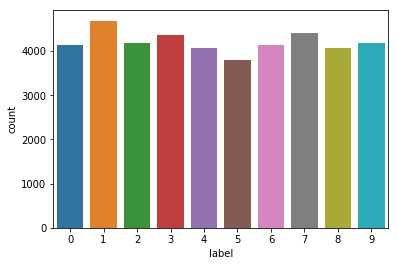

In [5]:
g = sns.countplot(Y_train)
Y_train.value_counts()

In [6]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
X_train = X_train / 255.0
test = test /255.0

In [9]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [10]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input,Activation, AveragePooling2D, BatchNormalization
from keras import layers
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [11]:
Y_train = to_categorical(Y_train, num_classes=10)
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [12]:
def residual_block(a, filters):
    for i in range(3):
        x = BatchNormalization()(a)
        x = Activation('relu')(x)
        x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        x = layers.add([x, a])
    x = MaxPool2D(pool_size=(1,1), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=filters*2,kernel_size=1,padding='same')(x)
    return x

input_layer = Input(shape=(28,28,1))
x = Conv2D(filters=64, kernel_size=7, padding='same')(input_layer)
x = MaxPool2D(pool_size=(2,2))(x)

x = residual_block(x,64)
x = residual_block(x,128)
x = AveragePooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=x)

In [13]:
optimizer = Adam()

In [14]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy",metrics=["accuracy"])

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
early_stopping = EarlyStopping(patience=5)

In [16]:
epochs = 200 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 2048

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [18]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/200
 - 10s - loss: 1.3249 - acc: 0.5744 - val_loss: 0.5105 - val_acc: 0.8657
Epoch 2/200
 - 9s - loss: 0.2762 - acc: 0.9206 - val_loss: 0.3190 - val_acc: 0.9121
Epoch 3/200
 - 8s - loss: 0.1436 - acc: 0.9563 - val_loss: 0.4941 - val_acc: 0.8321
Epoch 4/200
 - 8s - loss: 0.1002 - acc: 0.9694 - val_loss: 0.5667 - val_acc: 0.8210
Epoch 5/200
 - 9s - loss: 0.0812 - acc: 0.9745 - val_loss: 0.2726 - val_acc: 0.9117

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/200
 - 9s - loss: 0.0670 - acc: 0.9795 - val_loss: 0.1489 - val_acc: 0.9498
Epoch 7/200
 - 9s - loss: 0.0600 - acc: 0.9819 - val_loss: 0.3730 - val_acc: 0.8781
Epoch 8/200
 - 9s - loss: 0.0567 - acc: 0.9828 - val_loss: 0.1530 - val_acc: 0.9505
Epoch 9/200
 - 9s - loss: 0.0519 - acc: 0.9838 - val_loss: 0.1458 - val_acc: 0.9533
Epoch 10/200
 - 9s - loss: 0.0528 - acc: 0.9845 - val_loss: 0.2286 - val_acc: 0.9224
Epoch 11/200
 - 9s - loss: 0.0465 - acc: 0.9863 - val_loss: 0.0809 - val_acc:

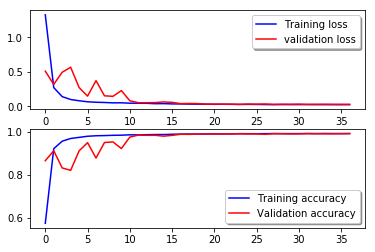

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [21]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)